In [46]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly_resampler import register_plotly_resampler, FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
from scipy.signal import find_peaks, savgol_filter, oaconvolve, detrend, windows
from scipy.fft import fft, fftfreq, ifft
from scipy.stats import linregress
import matplotlib.pyplot as plt
import plotly.io as pio
pio.kaleido.scope.mathjax = None

register_plotly_resampler(mode='auto')

In [102]:
def csv_to_dataframe(force_csv=str, mm_csv=str):

    if mm_csv == None:
        mm_df = pd.read_csv(force_csv, header=0)
    
    else:
        force_df = pd.read_csv(force_csv, header=1, names=['time', 'x_force', 'y_force'], usecols=[0,1,2])
        mm_df = pd.read_csv(mm_csv, header=1, names=['time', 'x_disp', 'y_disp', 'y_motor_disp', 'x_motor_disp'], usecols=[0,1,2,3,4])

            # add x_force and y_force to the main dataframe
        mm_df['x_force'] = force_df['x_force']
        mm_df['y_force'] = force_df['y_force']

    return mm_df

# jbzq04_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp1-2023-06-16-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp1-2023-06-16-mm.csv')

# flat_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/old_flat/camera_test_smoothsmooth_kn.csv',
#                                     'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/old_flat/camera_test_smoothsmooth_mm.csv')

# flat_dataframe_2 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/old_flat/camera_test_smoothsmooth_kn_2.csv',
#                                     'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/old_flat/camera_test_smoothsmooth_mm_2.csv')

# jbzq04_dataframe_2 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp2-2023-07-21-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp2-2023-07-21-mm.csv')

# jbzq04_dataframe_3 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp3-2023-11-04-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp3-2023-11-04-mm.csv')

# jbzq04_dataframe_4 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp4-2023-11-06-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp4-2023-11-06-mm.csv')

# jbzq05_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ05/JBZQ05-exp1-2023-11-21-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ05/JBZQ05-exp1-2023-11-21-mm.csv')

# smoothvsmooth_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/smoothvsmooth-2023-11-22-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/smoothvsmooth-2023-11-22-mm.csv')

# roughvsmooth_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvsmooth-2023-11-21-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvsmooth-2023-11-21-mm.csv')

# roughvrough_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvrough-2023-11-27-kn.csv',
#                                         'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvrough-2023-11-27-mm.csv')

control_dataframe_1 = csv_to_dataframe('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/cement_control/JAB_control02_072323(kN).csv',
                                        'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/cement_control/JAB_control02_072323(mm).csv')

In [84]:
def fft_plot(data):
    
    # Number of points
    N = data.shape[0]

    # Sampling rate (# points / range of values, in points/distance)
    sampling_rate = N / (data.max(axis=0)['x_disp'] - data.min(axis=0)['x_disp'])
    T = 1 / sampling_rate # Sampling period

    # FFT of the raw friction data
    friction_fft = fft(data['friction'].values)

    # Frequencies of the FFT
    friction_fft_freq = fftfreq(N, T)

    # Filtering high frequencies and very low frequencies from the FFT
    friction_fft[np.where(np.logical_and(abs(friction_fft_freq)>=400, abs(friction_fft_freq)<=5000))] = 0
    # friction_fft[np.where(np.logical_and(abs(friction_fft_freq)>=2.45, abs(friction_fft_freq)<=2.5))] = 0

    # Inverse FFT to return smoothed signal to the time domain
    inverse_friction = ifft(friction_fft)

    # Applying Hann window to the smoothed (inversed) signal to kill edge artifacts (tapering)
    # inverse_friction = windows.tukey(len(inverse_friction), 0.05) * inverse_friction

    # Setting 'friction' column in dataframe to the smoothed signal
    data['friction'] = inverse_friction

    # plt.plot(np.arange(0, N), inverse_friction * 100)
    # plt.plot(friction_fft_freq, abs(friction_fft))
    # plt.ylim(-0.3, 0.3)
    # plt.xlim(0, 20)
    # plt.grid()
    # plt.show()

    return data

In [4]:
def add_cols(dataframe):

    # Add friction (F / x = k)
    dataframe['friction'] = -dataframe['x_force'] / dataframe['y_force']

    # Cropping data so friction is between 0 and 1
    dataframe = dataframe[dataframe['friction'] > 0]

    dataframe = dataframe[dataframe['friction'] < 1]

    # Mean velocity
    dataframe['x_speed'] = np.gradient(dataframe['x_motor_disp'], dataframe['time'])
    # displacement['x_speed'] = displacement['x_speed'].rolling(2000).mean()
    dataframe['x_speed'] = dataframe['x_speed'].rolling(200).median()

    # Rate of change of friction wrt displacement
    dataframe['friction_slope'] = np.gradient(dataframe['friction'], dataframe['x_motor_disp'])

    return dataframe

def find_stress_drops(dataframe, window_size, stddev_coef):

    dataframe['troughs'] = False
    dataframe['peaks'] = False
    dataframe['friction_drop'] = 0

    # Loading the friction (stress drops = inverted peaks)
    friction = dataframe['friction']
    friction_slope = dataframe['friction_slope']

    """BELOW HERE IS THE NEW STRESS DROP DETECTION ALGORITHM, BASED ON X_DISP JUMPS
    # Loading the x_disp (Transducer data, not motor)
    x_disp = dataframe['x_disp']

    # Normalize the x_disp
    x_disp = (x_disp - np.min(x_disp))/(np.max(x_disp) - np.min(x_disp))

    ABOVE HERE IS THE NEW STRESS DROP DETECTION ALGORITHM, BASED ON X_DISP JUMPS"""

    """BELOW HERE IS THE OLD STRESS DROP DETECTION ALGORITHM, BASED ON FIRST DIFFERENCE OF FRICTION"""

    # Normalizing the inverted friction
    friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))
    friction = (friction - np.min(friction))/(np.max(friction) - np.min(friction))

    # Detect peaks of a certain prominence, and minimum distance from each other
    troughs, _ = find_peaks(-1*friction_slope, distance=20, prominence=0.1) # threshold=30, prominence=120

    # Calculate the standard dev of the friction slope data
    stddev = np.std(friction_slope)
    mean = np.mean(friction_slope)

    # Convert friction slope to numpy array
    friction_slope = friction_slope.to_numpy()
    friction = friction.to_numpy()

    # filter troughs < 'stddev_coef' std from mean, take initial length of list to calculate drop %
    pre_len = len(troughs)
    troughs = [trough for trough in troughs if abs(friction_slope[trough] - mean) > stddev_coef*stddev]

    """ABOVE HERE IS THE OLD STRESS DROP DETECTION ALGORITHM, BASED ON FIRST DIFFERENCE OF FRICTION"""

    # For each index in troughs, check to see if there is a lower friction value in the last 15 samples (false pick)
    # Then search indices surrounding the trough pick to see if there are lower values (true drop)
    for trough in troughs:
        if trough >= 15: # Above index of 15, to solve any indexing issues. Introduces error as nothing i<15 will be affected
            if np.min(friction[trough-15:trough]) < friction[trough]: # Check for lower friction value in i-15
                troughs.remove(trough)

        # Checks friction values locally to find true stress drop trough
        if troughs != [] and trough in troughs and trough >= 3 and trough <= len(dataframe) - 4:
            # If the pick is too far forward (+ X +/-)
            # This deals with the flat case too (moved the stress drop to the left as far as possible)
            while friction[trough] - friction[trough - 1] >= 0 and friction[trough] - friction[trough + 1] <= 0:
                troughs.remove(trough) # Removing peak in peaks list
                trough = trough - 1 # Replacing peak with peak - 1
                troughs.append(trough) # Replacing peak value in peaks list (with peak - 1)
            print(trough, friction[trough], friction[trough - 1], friction[trough + 1])
            while friction[trough] - friction[trough + 1] >= 0 and trough < len(dataframe) - 2:
                troughs.remove(trough) # Removing peak in peaks list
                trough = trough + 1 # Replacing peak with peak - 1
                troughs.append(trough) # Replacing peak value in peaks list (with peak - 1)
                print(trough, friction[trough], friction[trough - 1], friction[trough + 1])
                print(friction[trough] - friction[trough + 1] >= 0 and trough < len(dataframe) - 2)

    # Iterate over each peak and look for the maximum friction value in the last 5 indices to find
    # the stress "peak" preceding the drop
    peaks = troughs.copy()

    for peak in peaks:
        if peaks!= [] and peak >= 5: # Only look at peaks above i=5, to solve any indexing issues (also check for empty list)
            while friction[peak] - friction[peak - 1] <= 0: # While the previous point's friction value is higher
                peaks.remove(peak) # Remove the current value, replace with the point before it
                peak = peak - 1
                peaks.append(peak)

    # Calculate the friction drop between each peak/trough pair
    friction = dataframe['friction'].to_numpy() # redifine so it's not normalized

    friction_drops = []

    for peak, trough in zip(peaks, troughs):    

        if peak == trough or friction[peak] - friction[trough] <= 0.01:
            peaks.remove(peak)
            troughs.remove(trough)
            continue

        else:
            friction_drops.append(friction[peak] - friction[trough])

    # print dropped # of peaks
    post_len = len(troughs)
    drop_count = pre_len - post_len
    print(f'Dopped {drop_count} picks')

    # plt.plot(np.arange(0, len(friction_slope)), friction_slope)
    # plt.plot(np.arange(0, len(friction)), friction)
    # plt.scatter(peaks, friction[peaks])
    # plt.axhline(stddev_coef*stddev + mean)
    # plt.axhline(-stddev_coef*stddev + mean)
    # plt.show()

    # dataframe['peaks'].iloc[peaks] = True

    # stress_drops = dataframe.loc[force['peaks'] == True]

    return peaks, troughs, friction_drops

def add_stress_drops(dataframe, window_size, stddev_coef):

    # List of True/False values that will be turned into a df (force) column, where 
    peak_list = []
    trough_list = []
    friction_drop_list = []

    # Dividing the df into chunks of window_size
    for chunk in np.array_split(dataframe, len(dataframe) // window_size + 1):
        
        # Chunk-length list of Falses
        peak_temp_list = np.full(len(chunk), False)
        trough_temp_list = np.full(len(chunk), False)
        friction_drop_temp_list = list(np.full(len(chunk), 0))
        
        # Find peaks
        peaks, troughs, friction_drops = find_stress_drops(chunk, window_size, stddev_coef)

        # Replace False temp_lists with True where peaks are
        peak_temp_list[peaks] = True
        trough_temp_list[troughs] = True

        for trough, friction_drop in zip(troughs, friction_drops):
           friction_drop_temp_list[trough] = friction_drop

        # Adding the temp_lists to the main _lists
        peak_list = peak_list + list(peak_temp_list)
        trough_list = trough_list + list(trough_temp_list)
        friction_drop_list = friction_drop_list + list(friction_drop_temp_list)
        
        print(f'{len(trough_list)} / {len(dataframe)}')

    dataframe['peaks'] = peak_list
    dataframe['troughs'] = trough_list
    dataframe['friction_drops'] = friction_drop_list

    # stress_drops = force.loc[force['troughs'] == True]

    return dataframe

def pick_velocity(stated_velocity):
    stated_velocity = float(stated_velocity)

    low = stated_velocity - stated_velocity*0.15
    high = stated_velocity + stated_velocity*0.15
    return low, high

def pick_force(stated_force):
    stated_force = float(stated_force)

    low = stated_force - stated_force*0.15
    high = stated_force + stated_force*0.15
    return low, high

def save_csv(dataframe, name):
    dataframe.to_csv(name, index=False)

In [6]:
# JBZQ04 1
jbzq04_dataframe_1 = add_cols(jbzq04_dataframe_1)

jbzq04_dataframe_1 = add_stress_drops(jbzq04_dataframe_1, 320, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encounter

Dopped 3 picks
320 / 3603614
Dopped 2 picks
640 / 3603614
Dopped 3 picks
960 / 3603614
Dopped 1 picks
1280 / 3603614
Dopped 0 picks
1600 / 3603614
Dopped 0 picks
1920 / 3603614
Dopped 0 picks
2240 / 3603614
Dopped 0 picks
2560 / 3603614
Dopped 0 picks
2880 / 3603614
Dopped 0 picks
3200 / 3603614
Dopped 0 picks
3520 / 3603614
Dopped 0 picks
3840 / 3603614
Dopped 0 picks
4160 / 3603614
Dopped 0 picks
4480 / 3603614
Dopped 0 picks
4800 / 3603614
Dopped 0 picks
5120 / 3603614
Dopped 0 picks
5440 / 3603614
Dopped 0 picks
5760 / 3603614
Dopped 0 picks
6080 / 3603614
Dopped 0 picks
6400 / 3603614
Dopped 0 picks
6720 / 3603614
Dopped 0 picks
7040 / 3603614
Dopped 0 picks
7360 / 3603614
Dopped 0 picks
7680 / 3603614
Dopped 0 picks
8000 / 3603614
Dopped 0 picks
8320 / 3603614
Dopped 0 picks
8640 / 3603614
Dopped 0 picks
8960 / 3603614
Dopped 0 picks
9280 / 3603614
Dopped 0 picks
9600 / 3603614
Dopped 0 picks
9920 / 3603614
Dopped 0 picks
10240 / 3603614
Dopped 0 picks
10560 / 3603614
Dopped 0 pi

C:\Users\stickslip\AppData\Local\Temp\ipykernel_14396\13596309.py:43: RuntimeWarning: invalid value encountered in scalar subtract
  friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))


In [7]:
# save_csv(jbzq04_dataframe_1, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp1-processed.csv')

In [8]:
# JBZQ04 2
jbzq04_dataframe_2 = add_cols(jbzq04_dataframe_2)

jbzq04_dataframe_2 = add_stress_drops(jbzq04_dataframe_2, 320, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encounter

Dopped 0 picks
320 / 4044430
Dopped 0 picks
640 / 4044430
Dopped 0 picks
960 / 4044430
Dopped 0 picks
1280 / 4044430
Dopped 0 picks
1600 / 4044430
Dopped 0 picks
1920 / 4044430
Dopped 0 picks
2240 / 4044430
Dopped 0 picks
2560 / 4044430
Dopped 0 picks
2880 / 4044430
Dopped 0 picks
3200 / 4044430
Dopped 0 picks
3520 / 4044430
Dopped 0 picks
3840 / 4044430
Dopped 0 picks
4160 / 4044430
Dopped 0 picks
4480 / 4044430
Dopped 0 picks
4800 / 4044430
Dopped 0 picks
5120 / 4044430
Dopped 0 picks
5440 / 4044430
Dopped 0 picks
5760 / 4044430
Dopped 0 picks
6080 / 4044430
Dopped 0 picks
6400 / 4044430
Dopped 0 picks
6720 / 4044430
Dopped 0 picks
7040 / 4044430
Dopped 0 picks
7360 / 4044430
Dopped 0 picks
7680 / 4044430
Dopped 0 picks
8000 / 4044430
Dopped 0 picks
8320 / 4044430
Dopped 0 picks
8640 / 4044430
Dopped 0 picks
8960 / 4044430
Dopped 0 picks
9280 / 4044430
Dopped 0 picks
9600 / 4044430
Dopped 0 picks
9920 / 4044430
Dopped 0 picks
10240 / 4044430
Dopped 0 picks
10560 / 4044430
Dopped 0 pi

C:\Users\stickslip\AppData\Local\Temp\ipykernel_14396\13596309.py:43: RuntimeWarning: invalid value encountered in scalar subtract
  friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))


In [9]:
# save_csv(jbzq04_dataframe_2, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp2-processed.csv')

In [10]:
# JBZQ04 3
jbzq04_dataframe_3 = add_cols(jbzq04_dataframe_3)

jbzq04_dataframe_3 = add_stress_drops(jbzq04_dataframe_3, 1000, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encounter

Dopped 0 picks
1000 / 3616813
Dopped 8 picks
2000 / 3616813
Dopped 18 picks
3000 / 3616813
Dopped 17 picks
4000 / 3616813
Dopped 3 picks
5000 / 3616813
Dopped 6 picks
6000 / 3616813
Dopped 1 picks
7000 / 3616813
Dopped 1 picks
8000 / 3616813
Dopped 0 picks
9000 / 3616813
Dopped 0 picks
10000 / 3616813
Dopped 0 picks
11000 / 3616813
Dopped 0 picks
12000 / 3616813
Dopped 0 picks
13000 / 3616813
Dopped 0 picks
14000 / 3616813
Dopped 0 picks
15000 / 3616813
Dopped 0 picks
16000 / 3616813
Dopped 0 picks
17000 / 3616813
Dopped 0 picks
18000 / 3616813
Dopped 0 picks
19000 / 3616813
Dopped 0 picks
20000 / 3616813
Dopped 0 picks
21000 / 3616813
Dopped 0 picks
22000 / 3616813
Dopped 0 picks
23000 / 3616813
Dopped 0 picks
24000 / 3616813
Dopped 0 picks
25000 / 3616813
Dopped 0 picks
26000 / 3616813
Dopped 0 picks
27000 / 3616813
Dopped 0 picks
28000 / 3616813
Dopped 0 picks
29000 / 3616813
Dopped 0 picks
30000 / 3616813
Dopped 0 picks
31000 / 3616813
Dopped 0 picks
32000 / 3616813
Dopped 0 picks


C:\Users\stickslip\AppData\Local\Temp\ipykernel_14396\13596309.py:43: RuntimeWarning: invalid value encountered in scalar subtract
  friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))


In [11]:
# save_csv(jbzq04_dataframe_3, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp3-processed.csv')

In [12]:
# JBZQ04 4
jbzq04_dataframe_4 = add_cols(jbzq04_dataframe_4)

jbzq04_dataframe_4 = add_stress_drops(jbzq04_dataframe_4, 1000, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encounter

Dopped 0 picks
1000 / 3847606
Dopped 0 picks
2000 / 3847606
Dopped 0 picks
3000 / 3847606
Dopped 0 picks
4000 / 3847606
Dopped 0 picks
5000 / 3847606
Dopped 0 picks
6000 / 3847606
Dopped 0 picks
7000 / 3847606
Dopped 0 picks
8000 / 3847606
Dopped 0 picks
9000 / 3847606
Dopped 0 picks
10000 / 3847606
Dopped 0 picks
11000 / 3847606
Dopped 0 picks
12000 / 3847606
Dopped 0 picks
13000 / 3847606
Dopped 0 picks
14000 / 3847606
Dopped 0 picks
15000 / 3847606
Dopped 0 picks
16000 / 3847606
Dopped 0 picks
17000 / 3847606
Dopped 0 picks
18000 / 3847606
Dopped 0 picks
19000 / 3847606
Dopped 0 picks
20000 / 3847606
Dopped 0 picks
21000 / 3847606
Dopped 0 picks
22000 / 3847606
Dopped 0 picks
23000 / 3847606
Dopped 0 picks
24000 / 3847606
Dopped 0 picks
25000 / 3847606
Dopped 0 picks
26000 / 3847606
Dopped 0 picks
27000 / 3847606
Dopped 0 picks
28000 / 3847606
Dopped 0 picks
29000 / 3847606
Dopped 0 picks
30000 / 3847606
Dopped 0 picks
31000 / 3847606
Dopped 0 picks
32000 / 3847606
Dopped 0 picks
33

C:\Users\stickslip\AppData\Local\Temp\ipykernel_14396\13596309.py:43: RuntimeWarning: invalid value encountered in scalar subtract
  friction_slope = (friction_slope - np.min(friction_slope))/(np.max(friction_slope) - np.min(friction_slope))


In [13]:
# save_csv(jbzq04_dataframe_4, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp4-processed.csv')

In [74]:
# jbzq05
jbzq05_dataframe_1 = add_cols(jbzq05_dataframe_1)

jbzq05_dataframe_1 = add_stress_drops(jbzq05_dataframe_1, 500, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 0 picks
500 / 4276387
Dopped 0 picks
1000 / 4276387
Dopped 0 picks
1500 / 4276387
Dopped 0 picks
2000 / 4276387
Dopped 0 picks
2500 / 4276387
Dopped 0 picks
3000 / 4276387
Dopped 0 picks
3500 / 4276387
Dopped 0 picks
4000 / 4276387
Dopped 0 picks
4500 / 4276387
Dopped 0 picks
5000 / 4276387
Dopped 0 picks
5500 / 4276387
Dopped 0 picks
6000 / 4276387
Dopped 0 picks
6500 / 4276387
Dopped 0 picks
7000 / 4276387
Dopped 0 picks
7500 / 4276387
Dopped 0 picks
8000 / 4276387
Dopped 0 picks
8500 / 4276387
Dopped 0 picks
9000 / 4276387
Dopped 0 picks
9500 / 4276387
Dopped 0 picks
10000 / 4276387
Dopped 0 picks
10500 / 4276387
Dopped 0 picks
11000 / 4276387
Dopped 0 picks
11500 / 4276387
Dopped 0 picks
12000 / 4276387
Dopped 0 picks
12500 / 4276387
Dopped 0 picks
13000 / 4276387
Dopped 0 picks
13500 / 4276387
Dopped 0 picks
14000 / 4276387
Dopped 0 picks
14500 / 4276387
Dopped 0 picks
15000 / 4276387
Dopped 0 picks
15500 / 4276387
Dopped 0 picks
16000 / 4276387
Dopped 0 picks
16500 / 42763

C:\Users\stickslip\AppData\Local\Temp\ipykernel_8788\13596309.py:43: RuntimeWarning:

invalid value encountered in scalar subtract



In [75]:
# save_csv(jbzq05_dataframe_1, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ05/JBZQ05-exp1-processed.csv')

In [82]:
smoothvsmooth_dataframe_1 = add_cols(smoothvsmooth_dataframe_1)

smoothvsmooth_dataframe_1 = add_stress_drops(smoothvsmooth_dataframe_1, 300, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 6 picks
300 / 3376103
Dopped 3 picks
600 / 3376103
Dopped 1 picks
900 / 3376103
Dopped 0 picks
1200 / 3376103
Dopped 0 picks
1500 / 3376103
Dopped 0 picks
1800 / 3376103
Dopped 0 picks
2100 / 3376103
Dopped 0 picks
2400 / 3376103
Dopped 0 picks
2700 / 3376103
Dopped 0 picks
3000 / 3376103
Dopped 0 picks
3300 / 3376103
Dopped 0 picks
3600 / 3376103
Dopped 0 picks
3900 / 3376103
Dopped 0 picks
4200 / 3376103
Dopped 0 picks
4500 / 3376103
Dopped 0 picks
4800 / 3376103
Dopped 0 picks
5100 / 3376103
Dopped 0 picks
5400 / 3376103
Dopped 0 picks
5700 / 3376103
Dopped 0 picks
6000 / 3376103
Dopped 0 picks
6300 / 3376103
Dopped 0 picks
6600 / 3376103
Dopped 0 picks
6900 / 3376103
Dopped 0 picks
7200 / 3376103
Dopped 0 picks
7500 / 3376103
Dopped 0 picks
7800 / 3376103
Dopped 0 picks
8100 / 3376103
Dopped 0 picks
8400 / 3376103
Dopped 0 picks
8700 / 3376103
Dopped 0 picks
9000 / 3376103
Dopped 0 picks
9300 / 3376103
Dopped 0 picks
9600 / 3376103
Dopped 0 picks
9900 / 3376103
Dopped 0 pick

C:\Users\stickslip\AppData\Local\Temp\ipykernel_9872\13596309.py:43: RuntimeWarning:

invalid value encountered in scalar subtract



In [85]:
# save_csv(smoothvsmooth_dataframe_1, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/smoothvsmooth-2023-11-22-kn-processed.csv')

In [86]:
roughvsmooth_dataframe_1 = add_cols(roughvsmooth_dataframe_1)

roughvsmooth_dataframe_1 = add_stress_drops(roughvsmooth_dataframe_1, 1000, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 0 picks
1000 / 3429597
Dopped 0 picks
2000 / 3429597
Dopped 0 picks
3000 / 3429597
Dopped 0 picks
4000 / 3429597
Dopped 0 picks
5000 / 3429597
Dopped 0 picks
6000 / 3429597
Dopped 1 picks
7000 / 3429597
Dopped 3 picks
8000 / 3429597
Dopped 0 picks
9000 / 3429597
Dopped 0 picks
10000 / 3429597
Dopped 0 picks
11000 / 3429597
Dopped 0 picks
12000 / 3429597
Dopped 0 picks
13000 / 3429597
Dopped 0 picks
14000 / 3429597
Dopped 0 picks
15000 / 3429597
Dopped 0 picks
16000 / 3429597
Dopped 0 picks
17000 / 3429597
Dopped 0 picks
18000 / 3429597
Dopped 0 picks
19000 / 3429597
Dopped 0 picks
20000 / 3429597
Dopped 0 picks
21000 / 3429597
Dopped 0 picks
22000 / 3429597
Dopped 0 picks
23000 / 3429597
Dopped 0 picks
24000 / 3429597
Dopped 0 picks
25000 / 3429597
Dopped 0 picks
26000 / 3429597
Dopped 0 picks
27000 / 3429597
Dopped 0 picks
28000 / 3429597
Dopped 0 picks
29000 / 3429597
Dopped 0 picks
30000 / 3429597
Dopped 0 picks
31000 / 3429597
Dopped 0 picks
32000 / 3429597
Dopped 0 picks
33

C:\Users\stickslip\AppData\Local\Temp\ipykernel_9872\13596309.py:43: RuntimeWarning:

invalid value encountered in scalar subtract



In [91]:
# save_csv(roughvsmooth_dataframe_1, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvsmooth-2023-11-21-kn-processed.csv')

In [89]:
roughvrough_dataframe_1 = add_cols(roughvrough_dataframe_1)

roughvrough_dataframe_1 = add_stress_drops(roughvrough_dataframe_1, 1000, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 0 picks
1000 / 3235384
Dopped 0 picks
2000 / 3235384
Dopped 0 picks
3000 / 3235384
Dopped 0 picks
4000 / 3235384
Dopped 0 picks
5000 / 3235384
Dopped 4 picks
6000 / 3235384
Dopped 14 picks
7000 / 3235384
Dopped 9 picks
8000 / 3235384
Dopped 2 picks
9000 / 3235384
Dopped 0 picks
10000 / 3235384
Dopped 0 picks
11000 / 3235384
Dopped 0 picks
12000 / 3235384
Dopped 0 picks
13000 / 3235384
Dopped 0 picks
14000 / 3235384
Dopped 0 picks
15000 / 3235384
Dopped 0 picks
16000 / 3235384
Dopped 0 picks
17000 / 3235384
Dopped 0 picks
18000 / 3235384
Dopped 0 picks
19000 / 3235384
Dopped 0 picks
20000 / 3235384
Dopped 0 picks
21000 / 3235384
Dopped 0 picks
22000 / 3235384
Dopped 0 picks
23000 / 3235384
Dopped 0 picks
24000 / 3235384
Dopped 0 picks
25000 / 3235384
Dopped 0 picks
26000 / 3235384
Dopped 0 picks
27000 / 3235384
Dopped 0 picks
28000 / 3235384
Dopped 0 picks
29000 / 3235384
Dopped 0 picks
30000 / 3235384
Dopped 0 picks
31000 / 3235384
Dopped 0 picks
32000 / 3235384
Dopped 0 picks
3

In [92]:
# save_csv(roughvrough_dataframe_1, 'C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvrough-2023-11-27-kn-processed.csv')

In [9]:
control_dataframe_1 = add_cols(control_dataframe_1)

control_dataframe_1 = add_stress_drops(control_dataframe_1, 500, 3)

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning:

invalid value encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning:

divide by zero encountered in divide

c:\Users\stickslip\Documents\leki-files\mcgill-natural-faults\lab-pc-env\Lib\site-packages\numpy\lib\functi

Dopped 0 picks
500 / 4227029
Dopped 0 picks
1000 / 4227029
Dopped 0 picks
1500 / 4227029
Dopped 0 picks
2000 / 4227029
Dopped 0 picks
2500 / 4227029
Dopped 0 picks
3000 / 4227029
Dopped 0 picks
3500 / 4227029
Dopped 0 picks
4000 / 4227029
Dopped 0 picks
4500 / 4227029
Dopped 0 picks
5000 / 4227029
Dopped 0 picks
5500 / 4227029
Dopped 0 picks
6000 / 4227029
Dopped 0 picks
6500 / 4227029
Dopped 0 picks
7000 / 4227029
Dopped 0 picks
7500 / 4227029
Dopped 0 picks
8000 / 4227029
Dopped 0 picks
8500 / 4227029
Dopped 0 picks
9000 / 4227029
Dopped 0 picks
9500 / 4227029
Dopped 0 picks
10000 / 4227029
Dopped 0 picks
10500 / 4227029
Dopped 0 picks
11000 / 4227029
Dopped 0 picks
11500 / 4227029
Dopped 0 picks
12000 / 4227029
Dopped 0 picks
12500 / 4227029
Dopped 0 picks
13000 / 4227029
Dopped 0 picks
13500 / 4227029
Dopped 0 picks
14000 / 4227029
Dopped 0 picks
14500 / 4227029
Dopped 0 picks
15000 / 4227029
Dopped 0 picks
15500 / 4227029
Dopped 0 picks
16000 / 4227029
Dopped 0 picks
16500 / 42270

C:\Users\stickslip\AppData\Local\Temp\ipykernel_12712\1618868169.py:43: RuntimeWarning:

invalid value encountered in scalar subtract



In [10]:
# sort by column
sort_value = 'x_motor_disp'

control_dataframe_1 = control_dataframe_1.sort_values(by=[sort_value])

# jbzq04_force_1 = jbzq04_force_1.sort_values(by=[sort_value])
smoothvsmooth_dataframe_1 = smoothvsmooth_dataframe_1.sort_values(by=[sort_value])
roughvsmooth_dataframe_1 = roughvsmooth_dataframe_1.sort_values(by=[sort_value])
roughvrough_dataframe_1 = roughvrough_dataframe_1.sort_values(by=[sort_value])

jbzq04_dataframe_1 = jbzq04_dataframe_1.sort_values(by=[sort_value])

jbzq04_dataframe_3 = jbzq04_dataframe_3.sort_values(by=[sort_value])

jbzq04_dataframe_4 = jbzq04_dataframe_4.sort_values(by=[sort_value])

jbzq04_dataframe_2 = jbzq04_dataframe_2.sort_values(by=[sort_value])

jbzq05_dataframe_1 = jbzq05_dataframe_1.sort_values(by=[sort_value])

NameError: name 'smoothvsmooth_dataframe_1' is not defined

In [4]:
# load in csv files

smoothvsmooth_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/smoothvsmooth-processed.csv')

roughvsmooth_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvsmooth-processed.csv')

roughvrough_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/new_flat/roughvrough-processed.csv')

In [5]:
# load in natural fault csv files

jbzq04_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp1-processed.csv')

jbzq04_dataframe_2 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp2-processed.csv')

jbzq04_dataframe_3 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp3-processed.csv')

jbzq04_dataframe_4 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ04/JBZQ04-exp4-processed.csv')

In [76]:
jbzq05_dataframe_1 = pd.read_csv('C:/Users/stickslip/Documents/leki-files/mcgill-natural-faults/surfaces/JBZQ05/JBZQ05-exp1-processed.csv')

In [107]:
def add_stress_drop_magnitude(dataframe):
    """ 
    For each friction_drop, calculate the magnitude of the x_force drop
    """

    dataframe['peak_x_force'] = 0
    dataframe['x_deficit'] = 0  

    # locate friction drop peaks and troughs
    stress_drop_peaks = dataframe.loc[dataframe['peaks'] == True]
    stress_drop_troughs = dataframe.loc[dataframe['troughs'] == True]

    # iterate over each stress drop peak and trough
    for peak, trough in zip(stress_drop_peaks.index, stress_drop_troughs.index):

        # skip if peak index is 4 less than the length of the dataframe
        if peak + 3 > len(dataframe):
            continue

        # calcualte the x_force at the peak and add it to the row with the corresponding trough
        # take absolute value to get magnitude
        peak_x_force = abs(dataframe['x_force'].iloc[peak])
        dataframe['peak_x_force'].iloc[trough] = peak_x_force

    # find the difference in x_disp between each stress drop peak and trough
    for peak, trough in zip(stress_drop_peaks.index, stress_drop_troughs.index):

        # skip if peak index is 4 less than the length of the dataframe
        if peak + 3 > len(dataframe):
            continue

        # calculate the x_deficit and add it to the row with the corresponding trough
        x_deficit = dataframe['x_disp'].iloc[trough] - dataframe['x_disp'].iloc[peak]

        # skip if x_deficit is negative
        if x_deficit < 0:
            continue
        
        dataframe['x_deficit'].iloc[trough] = x_deficit

    return dataframe

In [108]:
jbzq04_dataframe_1 = add_stress_drop_magnitude(jbzq04_dataframe_1)
jbzq04_dataframe_2 = add_stress_drop_magnitude(jbzq04_dataframe_2)
jbzq04_dataframe_3 = add_stress_drop_magnitude(jbzq04_dataframe_3)
jbzq04_dataframe_4 = add_stress_drop_magnitude(jbzq04_dataframe_4)
# jbzq05_dataframe_1 = add_stress_drop_magnitude(jbzq05_dataframe_1)

smoothvsmooth_dataframe_1 = add_stress_drop_magnitude(smoothvsmooth_dataframe_1)
roughvsmooth_dataframe_1 = add_stress_drop_magnitude(roughvsmooth_dataframe_1)
roughvrough_dataframe_1 = add_stress_drop_magnitude(roughvrough_dataframe_1)

C:\Users\stickslip\AppData\Local\Temp\ipykernel_22836\2027360402.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\stickslip\AppData\Local\Temp\ipykernel_22836\2027360402.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\stickslip\AppData\Local\Temp\ipykernel_22836\2027360402.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\stickslip\AppData\Local\Temp\ipykernel_22836\2027360402.py:39: SettingWithCo

In [13]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_1['x_motor_disp'], y=jbzq04_dataframe_1['friction'], name='JBZQ04 1', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=jbzq04_dataframe_1['x_motor_disp'], y=jbzq04_dataframe_1['x_speed'], name='JBZQ04 1', connectgaps=True, mode='lines'), secondary_y=True)

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_2['x_motor_disp'], y=jbzq04_dataframe_2['friction'], name='JBZQ04 2', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=jbzq04_dataframe_2['x_motor_disp'], y=jbzq04_dataframe_2['x_speed'], name='JBZQ04 2', connectgaps=True, mode='lines'), secondary_y=True)

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_3['x_motor_disp'], y=jbzq04_dataframe_3['friction'], name='JBZQ04 3', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=jbzq04_dataframe_3['x_motor_disp'], y=jbzq04_dataframe_3['x_speed'], name='JBZQ04 3', connectgaps=True, mode='lines'), secondary_y=True)

# fig.add_trace(go.Scatter(x=jbzq04_dataframe_4['x_motor_disp'], y=jbzq04_dataframe_4['friction'], name='JBZQ04 4', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=jbzq04_dataframe_4['x_motor_disp'], y=jbzq04_dataframe_4['x_speed'], name='JBZQ04 4', connectgaps=True, mode='lines'), secondary_y=True)

# fig.add_trace(go.Scatter(x=jbzq05_dataframe_1['x_motor_disp'], y=jbzq05_dataframe_1['friction'], name='JBZQ05 1', connectgaps=True, mode='lines'), secondary_y=False)

# fig.add_trace(go.Scatter(x=roughvsmooth_dataframe_1['x_motor_disp'], y=roughvsmooth_dataframe_1['friction'], name='Rough v Smooth', connectgaps=True, mode='lines+markers'), secondary_y=False)
# fig.add_trace(go.Scatter(x=roughvsmooth_dataframe_1['x_motor_disp'], y=roughvsmooth_dataframe_1['x_speed'], name='Rough v Smooth speed', connectgaps=True, mode='lines+markers'), secondary_y=True)
# fig.add_trace(go.Scatter(x=roughvsmooth_dataframe_1['x_motor_disp'], y=roughvsmooth_dataframe_1['y_force'], name='Rough v Smooth speed', connectgaps=True, mode='lines+markers'), secondary_y=True)

# fig.add_trace(go.Scatter(x=jbzq05_dataframe_1['x_motor_disp'].loc[jbzq05_dataframe_1['friction'] <= 0.44], y=jbzq05_dataframe_1['friction'].loc[jbzq05_dataframe_1['friction'] <= 0.44], name='JBZQ05 1', connectgaps=True, mode='lines+markers'), secondary_y=False)
# fig.add_trace(go.Scatter(x=jbzq05_dataframe_1['x_motor_disp'], y=jbzq05_dataframe_1['y_force'], name='JBZQ05 1 normal force', connectgaps=True, mode='lines+markers'), secondary_y=True)
# fig.add_trace(go.Scatter(x=jbzq05_dataframe_1['x_motor_disp'].loc[jbzq05_dataframe_1['troughs'] == True], y=jbzq05_dataframe_1['friction'].loc[jbzq05_dataframe_1['troughs'] == True], 
#                          name='Peaks', mode='markers'), secondary_y=False)
# fig.add_trace(go.Scatter(x=jbzq05_dataframe_1['x_motor_disp'], y=jbzq05_dataframe_1['x_speed'], name='JBZQ05 1 speed', connectgaps=True, mode='lines+markers'), secondary_y=True)

# fig.add_trace(go.Scatter(x=smoothvsmooth_dataframe_1['x_motor_disp'], y=smoothvsmooth_dataframe_1['friction'], name='Smooth v Smooth', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=smoothvsmooth_dataframe_1['x_motor_disp'], y=smoothvsmooth_dataframe_1['x_speed'], name='Smooth v Smooth speed', connectgaps=True, mode='lines'), secondary_y=True)

# fig.add_trace(go.Scatter(x=roughvsmooth_dataframe_1['x_motor_disp'], y=roughvsmooth_dataframe_1['friction'], name='Rough v Smooth', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=roughvsmooth_dataframe_1['x_motor_disp'], y=roughvsmooth_dataframe_1['x_speed'], name='Rough v Smooth speed', connectgaps=True, mode='lines'), secondary_y=True)

# fig.add_trace(go.Scatter(x=roughvrough_dataframe_1['x_motor_disp'], y=roughvrough_dataframe_1['friction'], name='Rough v Rough', connectgaps=True, mode='lines'), secondary_y=False)
# fig.add_trace(go.Scatter(x=roughvrough_dataframe_1['x_motor_disp'], y=roughvrough_dataframe_1['x_speed'], name='Rough v Rough speed', connectgaps=True, mode='lines'), secondary_y=True)

fig.add_trace(go.Scatter(x=control_dataframe_1['x_motor_disp'], y=control_dataframe_1['friction'], name='Control', connectgaps=True, mode='lines'), secondary_y=False)
fig.add_trace(go.Scatter(x=control_dataframe_1['x_motor_disp'].loc[control_dataframe_1['troughs'] == True], y=control_dataframe_1['friction'].loc[control_dataframe_1['troughs'] == True],
                            name='Peaks', mode='markers'), secondary_y=False)

# multiply for poster figure (2.1*), font=35
 fwefwe
fig.update_layout(width=1120, height=600, title='Friction vs. Displacement', xaxis_title='Displacement (mm)', yaxis_title='Friction Coefficient', font=dict(size=12), 
                    xaxis=dict(showgrid=False, zeroline=False), yaxis=dict(showgrid=False, zeroline=False, range=[0,0.75]), paper_bgcolor="rgba(0, 0, 0, 0)", plot_bgcolor="rgba(0, 0, 0, 0)")

# fig.write_image("countertop_friction", "svg")

IndentationError: unexpected indent (1643327400.py, line 41)

In [111]:
# restrict control_dataframe_1 between 28.1 and 30 mm
control_dataframe_1 = control_dataframe_1.loc[control_dataframe_1['x_motor_disp'] >= 28.13]
control_dataframe_1 = control_dataframe_1.loc[control_dataframe_1['x_motor_disp'] <= 30]

""" PEAK FINDING """

# find troughts within the restricted dataframe using scipy.signal.find_peaks
troughs, _ = find_peaks(-control_dataframe_1['y_force'], prominence=0.009, distance=200)
troughs = troughs[1:-1]
troughs = np.delete(troughs, [1, 2])

peaks, _ = find_peaks(control_dataframe_1['y_force'].rolling(50).median(), prominence=0.002, distance=200)
peaks = peaks[1:]
peaks = np.delete(peaks, [0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

""" FITTING """
# for each trough/peak pair, fit a line to the data
# calculate the slope of the line
slopes = []

for trough, peak in zip(troughs, peaks):
    slope, intercept, r_value, p_value, std_err = linregress(control_dataframe_1['x_motor_disp'].iloc[trough:peak], control_dataframe_1['y_force'].iloc[trough:peak])
    slopes.append(slope)

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=control_dataframe_1['x_motor_disp'].iloc[troughs], y=control_dataframe_1['y_force'].iloc[troughs],
                            name='Troughs', mode='markers'), secondary_y=False)

fig.add_trace(go.Scatter(x=control_dataframe_1['x_motor_disp'].iloc[peaks], y=control_dataframe_1['y_force'].iloc[peaks],
                            name='Peaks', mode='markers'), secondary_y=False)

fig.add_trace(go.Scatter(x=control_dataframe_1['x_motor_disp'], y=control_dataframe_1['y_force'], name='Control', connectgaps=True, mode='lines'), secondary_y=False)


FigureWidgetResampler({
    'data': [{'mode': 'markers',
              'name': 'Troughs',
              'type': 'scatter',
              'uid': '6148a521-8f03-478a-a8e1-e7d481945ef8',
              'x': array([28.15541439, 28.20286714, 28.21362671, ..., 29.97295745, 29.97999825,
                          29.98685744]),
              'xaxis': 'x',
              'y': array([2.37486364, 2.37167834, 2.41380944, ..., 2.43045861, 2.42840295,
                          2.4302102 ]),
              'yaxis': 'y'},
             {'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': '2f824496-74b3-4870-a3f8-43c42fa73348',
              'x': array([28.15656364, 28.20545807, 28.21628563, ..., 29.97613885, 29.98297662,
                          29.99007702]),
              'xaxis': 'x',
              'y': array([2.45307153, 2.45388488, 2.45300378, ..., 2.45433666, 2.45341039,
                          2.45424633]),
              'yaxis': 'y'},
        

In [112]:
print(slopes)

[17.964354292565645, 14.718402590338307, 7.595158076545869, 9.713711241974103, 3.4485749733401483, 12.213852337531998, 11.924599884009238, 3.752249104872972, 8.19435186005124, 9.536555811910825, 12.604927541585148, 4.348726262823647, 9.707785997931067, 12.324935934176727, 14.726212313435353, 10.95117682120926, 9.765268712492723, 4.113904466876286, 6.9893776676749395, 9.857107830429028, 10.325845857963229, 3.3086706137726583, 11.40469782592141, 11.439408646965424, 12.203997344328515, 12.413437525436175, 11.921460993838247, 11.331138015313078, 11.957361174530392, 11.36861056107901, 9.085870780203027, 12.965580749204046, 9.144824672336686, 9.454110980962792, 9.88244597802315, 13.389932155408172, 14.80428968710134, 10.699556637664346, 12.576451010269682, 12.764692138079162, 12.933787726684576, 11.79547445917808, 12.721131226269968, 4.939726102859052, 9.855221193884681, 9.531896802737757, 11.820536118635163, 5.049682811325172, 10.05482844249363, 9.749412475128443, 9.161097122920712, 10.8720

C:\Users\stickslip\AppData\Local\Temp\ipykernel_22836\3293515235.py:25: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



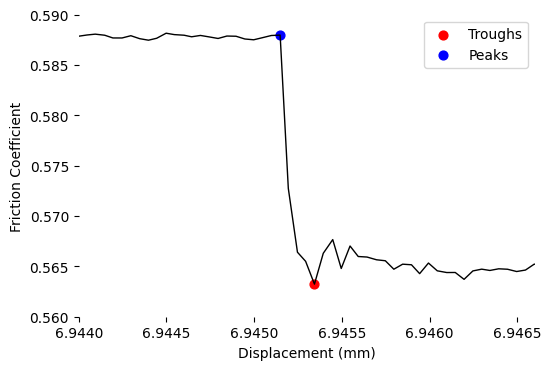

In [170]:
# plot jbzq04 4 friction between 6.94 and 6.955 mm using matplotlib

fig = plt.figure(figsize=(5.884, 3.923))

ax = fig.add_subplot(111)

ax.plot(jbzq04_dataframe_4['x_motor_disp'], jbzq04_dataframe_4['friction'], color='black', linewidth=1)
ax.scatter(jbzq04_dataframe_4['x_motor_disp'].loc[jbzq04_dataframe_4['troughs'] == True], jbzq04_dataframe_4['friction'].loc[jbzq04_dataframe_4['troughs'] == True],
            color='red', marker='o', s=40, label='Troughs')
ax.scatter(jbzq04_dataframe_4['x_motor_disp'].loc[jbzq04_dataframe_4['peaks'] == True], jbzq04_dataframe_4['friction'].loc[jbzq04_dataframe_4['peaks'] == True],
            color='blue', marker='o', s=40, label='Peaks')

ax.set_xlim(6.944, 6.9466)

ax.set_ylim(0.56, 0.59)

ax.set_xlabel('Displacement (mm)')
ax.set_ylabel('Friction Coefficient')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(loc='upper right')
plt.savefig('friction_drop.svg', transparent=True, bbox_inches='tight')
fig.show()


### Comparison

JBZQ04 2, SM1, AVLY02
SHS, 0.1 mm/s
10-24 mm

#### Stress drops at 0.1 mm/s
- JBZQ04 1 (10 kN): 31-36 mm
- JBZQ04 2 (5 kN): 8-13 mm, 21-25 mm
- JBZQ04 2 (3 kN): 38-43 mm, 51-55 mm, 60-64 mm
- SM1 (2.5 kN): 7-12 mm, 20-28 mm
- AVLY02 (2.5 kN): 8-13 mm, 21-29 mm, 34-39 mm, 47-55 mm, 60-65 mm, 73-78 mm

#### Holds at 0.1 mm/s
- JBZQ04 2 (5 kN): 13-21 mm, [30, 60, 120, 300, 600]
- JBZQ04 2 (3 kN): 43-51 mm, [30, 60, 120, 300, 600]; 64-74 mm, [30, 60, 120, 300, 600, 1200]
- SM1 (2.5 kN): 12-20 mm, [10, 60, 120, 600, 1200]; 38-46 mm, [10, 60, 120, 600, 1200]; 64-72 mm, [10, 60, 120, 600, 1200]
- AVLY02 (2.5 kN): 13-21 mm, [30, 60, 120, 300, 600]; 39-47 mm, [30, 60, 120, 300, 600]; 65-73 mm, [30, 60, 120, 300, 600]


In [109]:
# Make a new df from jbzq01_force_1, with only the stress drops
jbzq04_stress_drops_3 = jbzq04_dataframe_3.loc[jbzq04_dataframe_3['troughs'] == True]
# Drop stress drops that are too small
jbzq04_stress_drops_3 = jbzq04_stress_drops_3[jbzq04_stress_drops_3['friction_drops'] > 0.01]

jbzq04_stress_drops_4 = jbzq04_dataframe_4.loc[jbzq04_dataframe_4['troughs'] == True]
# Drop stress drops that are too small
jbzq04_stress_drops_4 = jbzq04_stress_drops_4[jbzq04_stress_drops_4['friction_drops'] > 0.01]

# Make a new df from jbzq01_force_1, with only the stress drops
jbzq04_stress_drops_1 = jbzq04_dataframe_1.loc[jbzq04_dataframe_1['troughs'] == True]
# Drop stress drops that are too small
jbzq04_stress_drops_1 = jbzq04_stress_drops_1[jbzq04_stress_drops_1['friction_drops'] > 0.01]
# only keep rows after x_motor_disp = 17

# Make a new df from jbzq01_force_1, with only the stress drops
jbzq04_stress_drops_2 = jbzq04_dataframe_2.loc[jbzq04_dataframe_2['troughs'] == True]
# Drop stress drops that are too small
jbzq04_stress_drops_2 = jbzq04_stress_drops_2[jbzq04_stress_drops_2['friction_drops'] > 0.01]

# new df smooth on smooth
smoothvsmooth_stress_drops_1 = smoothvsmooth_dataframe_1.loc[smoothvsmooth_dataframe_1['troughs'] == True]

# new df rough on smooth
roughvsmooth_stress_drops_1 = roughvsmooth_dataframe_1.loc[roughvsmooth_dataframe_1['troughs'] == True]

# new df rough on rough
roughvrough_stress_drops_1 = roughvrough_dataframe_1.loc[roughvrough_dataframe_1['troughs'] == True]


In [18]:
def plot_histogram(dataframe, variable, speeds, nbins, diff):
    """ 
    INPUTS:
    dataframe: DataFrame containing the data to be plotted
    variable: String of the variable to be plotted
    diff: Boolean, whether or not to take the first difference of the variable
    speeds: List of the speeds to be plotted
    nbins: Number of bins in the histogram
    """
    # Automatically calculate the range of the histograms by
    # setting it to include 90% of the data
    max_value = 0
    for speed in speeds:

        # Checking if empty
        if len(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]) != 0:  
            print(len(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]))

            # find the range between 0 and x that includes 93% of the data
            if diff == True:
                upper = np.percentile(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]), 90)
            else:
                upper = np.percentile(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))], 90)
                
            # Replacing max_value if the upper value is greater (extending range of histograms to accomodate "spreadiest" data)
            if upper > max_value:
                max_value = upper
    
    # Plot the histograms on the same figure as different axis
    fig, ax = plt.subplots()

    for speed in speeds:
        if diff == True:
            ax.hist(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]), bins=nbins, alpha=0.5, range=(0, max_value), label=f'{speed} mm/s')
            
            # also plot the mean
            # ax.axvline(np.mean(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))])), color='black', linestyle='dashed', linewidth=1)
        else:
            ax.hist(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))], bins=nbins, alpha=0.5, range=(0, max_value), label=f'{speed} mm/s')

            # also plot the mean
            ax.axvline(np.mean(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))]), color='black', linestyle='dashed', linewidth=1)

    ax.set_xlabel(f'{variable}')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()


def plot_variable_vs_velocity(dataframe, variable, speeds, forces, diff):
    """ 
    Make a plot where the x-axis is velocity, y-axis is the selected variable, and the y_force corresponding to each point is reflected by the point's color
    Some forces and speeds are missing

    INPUTS:
    dataframe: DataFrame containing the data to be plotted
    variable: String of the variable to be plotted
    speeds: List of the speeds to be plotted
    forces: List of the forces to be plotted (within 0.1 of the forces in y_force)
    
    OUTPUTS:
    Shows fig
    """
    # vars, stds lists
    vars, stds = [], []

    # Initiate figure
    fig, ax = plt.subplots()

    # Iterate over each speed
    for speed in speeds:
    
            # Iterate over each force
            for force in forces:
    
                # Check if there is data for the given speed and force
                if len(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))].loc[dataframe['y_force'].between(*pick_force(force))]) != 0:
                    print(len(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))].loc[dataframe['y_force'].between(*pick_force(force))]))
    
                    if diff == True:
                        # Plot the mean of the first difference of the variable, with error bars of the standard deviation
                        mean = np.mean(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))].loc[dataframe['y_force'].between(*pick_force(force))]))
                        std = 1# np.std(np.diff(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))].loc[dataframe['y_force'].between(*pick_force(force))]))
                        # ax.errorbar(speed, mean, yerr=std, fmt='o', label=f'{force} N', capsize=5)

                        # Append the mean and std to the lists
                        vars.append(mean)
                        stds.append(std)
                    
                    else:
                        mean = np.mean(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))].loc[dataframe['y_force'].between(*pick_force(force))])
                        std = np.std(dataframe[variable].loc[dataframe['x_speed'].between(*pick_velocity(speed))].loc[dataframe['y_force'].between(*pick_force(force))])
                        ax.errorbar(speed, mean, yerr=std, fmt='o', label=f'{force} N')

                        # Append the mean and std to the lists
                        vars.append(mean)
                        stds.append(std)
                    
    # plot
    ax.set_xlabel('Velocity (mm/s)')
    ax.set_ylabel(f'{variable}')
    ax.legend()
    plt.show()

    return vars, stds


8
402
143
60


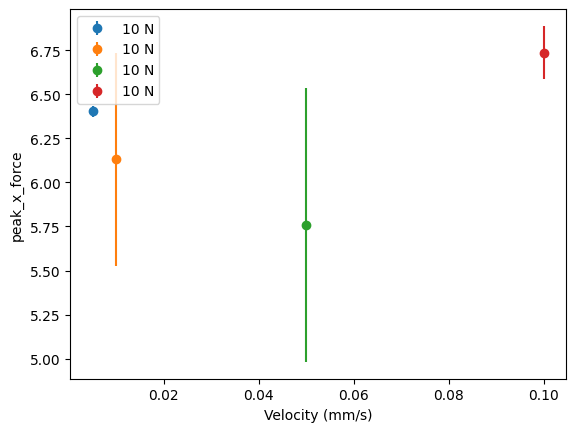

3
49
4


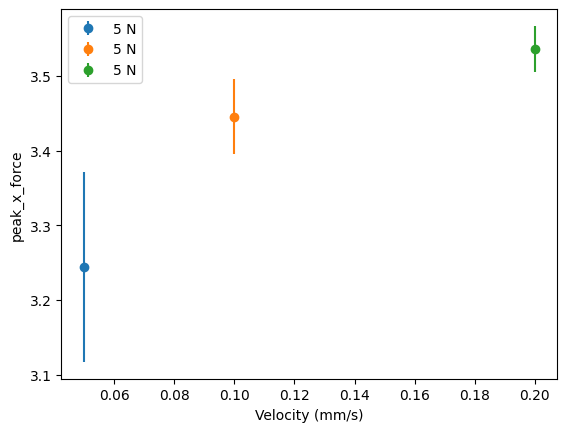

17
36
59
22
48


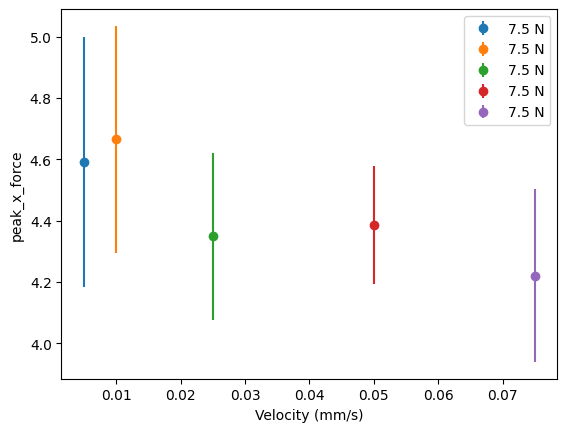

52
34
56
67
48


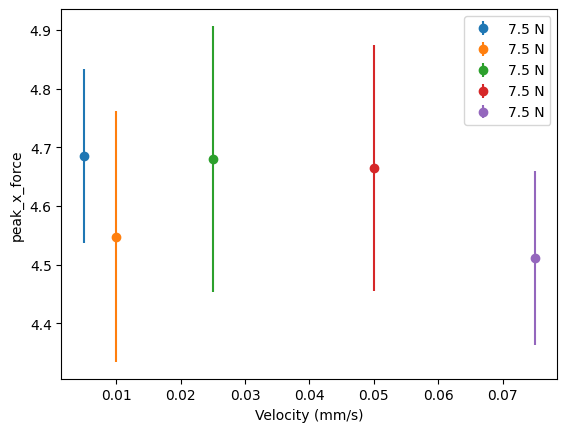

122
175
118
2


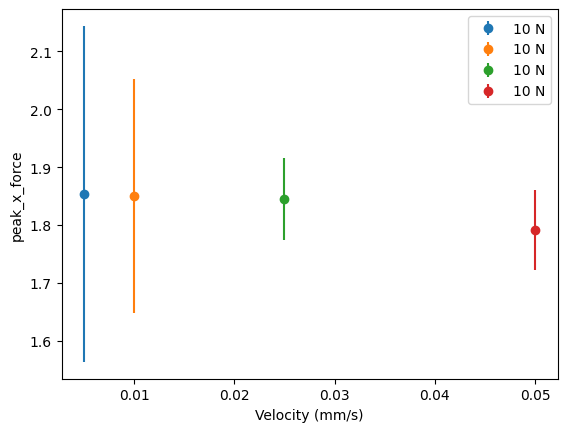

14
4
15
25


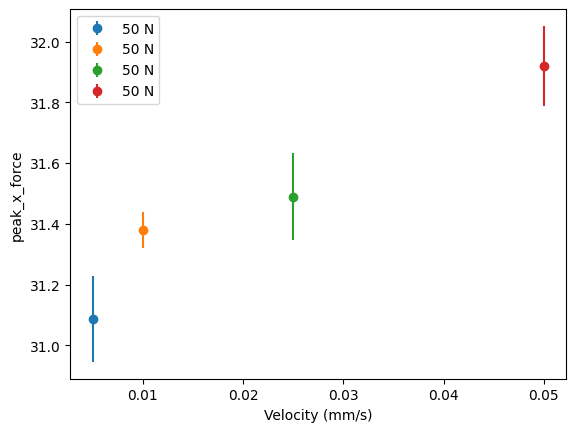

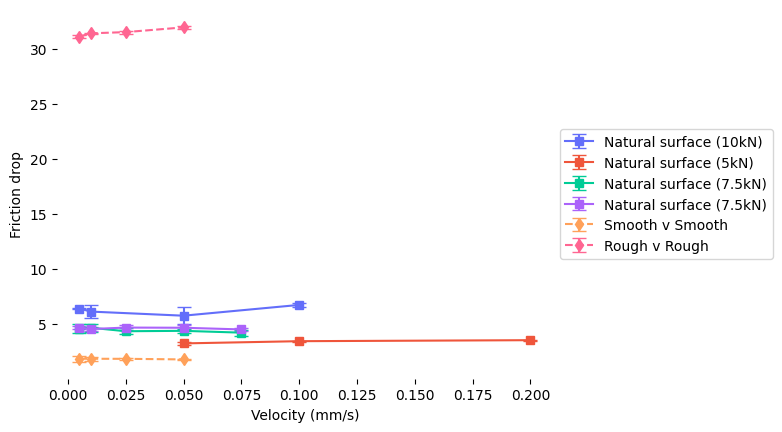

In [137]:
variable = 'peak_x_force'

j4sd1m, j4sd1s = plot_variable_vs_velocity(jbzq04_stress_drops_1, variable, [0.001, 0.005, 0.01, 0.025, 0.05, 0.1], [10], False)

j4sd2m, j4sd2s = plot_variable_vs_velocity(jbzq04_stress_drops_2, variable, [0.005, 0.01, 0.05, 0.1, 0.2], [5], False)

j4sd3m, j4sd3s = plot_variable_vs_velocity(jbzq04_stress_drops_3, variable, [0.001, 0.005, 0.01, 0.025, 0.05, 0.075], [7.5], False)

j4sd4m, j4sd4s = plot_variable_vs_velocity(jbzq04_stress_drops_4, variable, [0.001, 0.005, 0.01, 0.025, 0.05, 0.075], [7.5], False)
# f1_10m, f1_10s = plot_variable_vs_velocity(flat_stress_drops_1, variable, [0.01, 0.02, 0.03, 0.05, 0.1], [10], True)

# f1_20m, f1_20s = plot_variable_vs_velocity(flat_stress_drops_1, variable, [0.01, 0.02, 0.03, 0.05, 0.1], [20], True)

# j5sd1m, j5sd1s = plot_variable_vs_velocity(jbzq05_stress_drops_1, variable, [0.005, 0.01, 0.025, 0.05, 0.075], [1], True)

# j5sd2m, j5sd2s = plot_variable_vs_velocity(jbzq05_stress_drops_1, variable, [0.005, 0.01, 0.025, 0.05, 0.075], [2], True)

# j5sd1m, j5sd1s = plot_variable_vs_velocity(jbzq05_stress_drops_1, variable, [0.005, 0.01, 0.025, 0.05, 0.075], [5], True)

ssm, sss = plot_variable_vs_velocity(smoothvsmooth_stress_drops_1, variable, [0.005, 0.01, 0.025, 0.05], [10], False)

rrm, rrs = plot_variable_vs_velocity(roughvrough_stress_drops_1, variable, [0.005, 0.01, 0.025, 0.05], [50], False)


fig, ax = plt.subplots()

# set y to log
# ax.set_yscale('log')

ax.errorbar([0.005, 0.01, 0.05, 0.1], j4sd1m, yerr=j4sd1s, fmt='s-', label='Natural surface (10kN)', capsize=5, color='#636EFA')
ax.errorbar([0.05, 0.1, 0.2], j4sd2m, yerr=j4sd2s, fmt='s-', label='Natural surface (5kN)', capsize=5, color='#EF553B')
ax.errorbar([0.005, 0.01, 0.025, 0.05, 0.075], j4sd3m, yerr=j4sd3s, fmt='s-', label='Natural surface (7.5kN)', capsize=5, color='#00CC96')
ax.errorbar([0.005, 0.01, 0.025, 0.05, 0.075], j4sd4m, yerr=j4sd4s, fmt='s-', label='Natural surface (7.5kN)', capsize=5, color='#AB63FA')
ax.errorbar([0.005, 0.01, 0.025, 0.05], ssm, yerr=sss, fmt='d--', label='Smooth v Smooth', capsize=5, color='#FFA15A')
ax.errorbar([0.005, 0.01, 0.025, 0.05], rrm, yerr=rrs, fmt='d--', label='Rough v Rough', capsize=5, color='#FF6692')

# ax.errorbar([0.01, 0.02, 0.05], f1_10m, yerr=f1_10s, fmt='*--', label='Flat 1 (10kN)', capsize=5)
# ax.errorbar([0.01, 0.02, 0.05], f1_20m, yerr=f1_20s, fmt='x--', label='Flat 1 (20kN)', capsize=5)

ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Friction drop')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('../figures/friction_drop_vs_velocity.svg', bbox_inches='tight')
plt.show()

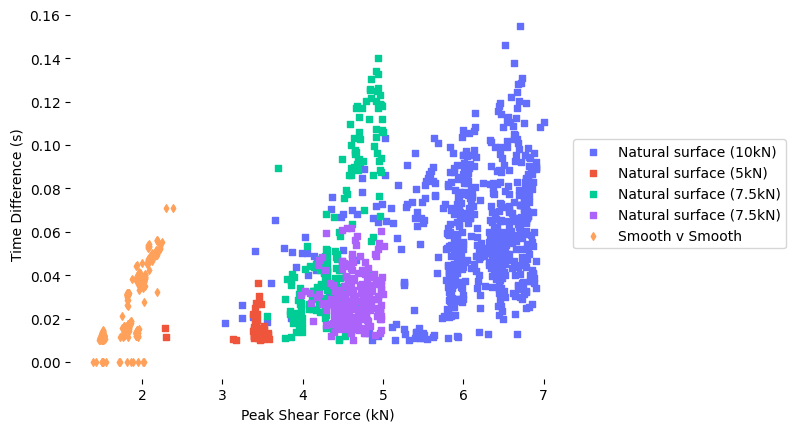

In [141]:
# plot friction drop against peak_x_force

fig, ax = plt.subplots()

varx = 'peak_x_force'
vary = 'friction_drops'

ax.scatter(jbzq04_stress_drops_1[varx], jbzq04_stress_drops_1[vary], label='Natural surface (10kN)', color='#636EFA', s=15, marker='s')
ax.scatter(jbzq04_stress_drops_2[varx], jbzq04_stress_drops_2[vary], label='Natural surface (5kN)', color='#EF553B', s=15, marker='s')
ax.scatter(jbzq04_stress_drops_3[varx], jbzq04_stress_drops_3[vary], label='Natural surface (7.5kN)', color='#00CC96', s=15, marker='s')
ax.scatter(jbzq04_stress_drops_4[varx], jbzq04_stress_drops_4[vary], label='Natural surface (7.5kN)', color='#AB63FA', s=15, marker='s')
ax.scatter(smoothvsmooth_stress_drops_1[varx], smoothvsmooth_stress_drops_1[vary], label='Smooth v Smooth', color='#FFA15A', s=15, marker='d')
# ax.scatter(roughvrough_stress_drops_1[varx], roughvrough_stress_drops_1[vary], label='Rough v Rough')

ax.set_xlabel('Peak Shear Force (kN)')
# ax.set_yscale('log')
ax.set_ylabel('Time Difference (s)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('../figures/logfrequency_vs_peak_shear_force.svg', bbox_inches='tight')
plt.show()

17
35
60
24


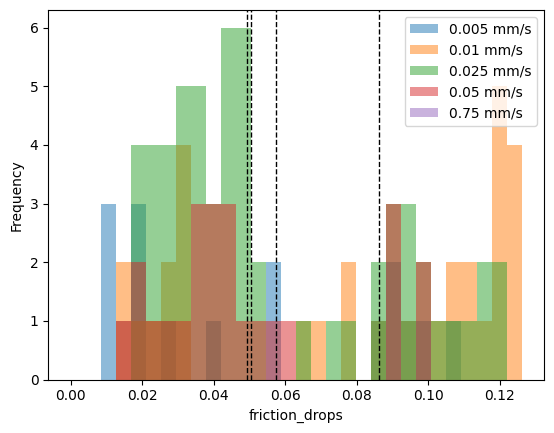

52
34
57
67


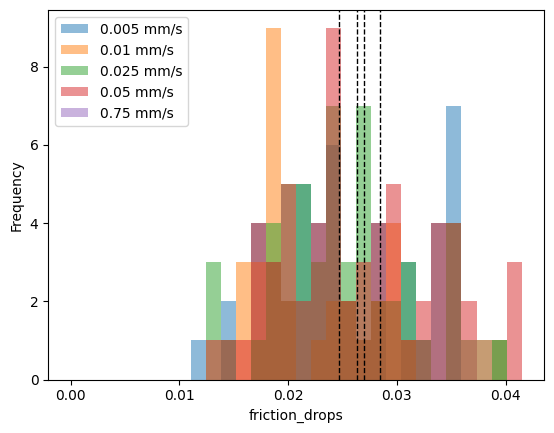

In [104]:
nbins = 30

plot_histogram(jbzq04_stress_drops_3, 'friction_drops', [0.005, 0.01, 0.025, 0.05, 0.75], nbins, False)

plot_histogram(jbzq04_stress_drops_4, 'friction_drops', [0.005, 0.01, 0.025, 0.05, 0.75], nbins, False)

139
90
40
13


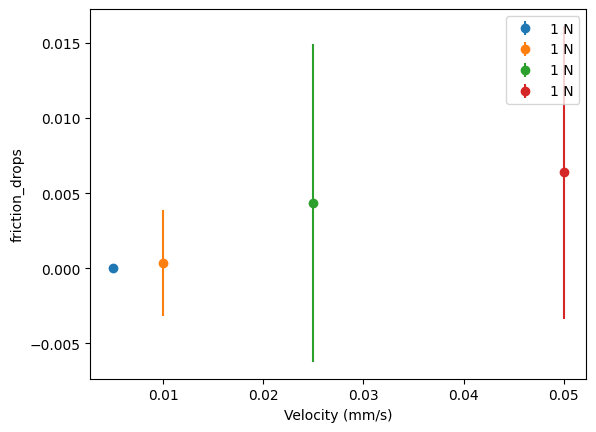

363
228
108
53
9


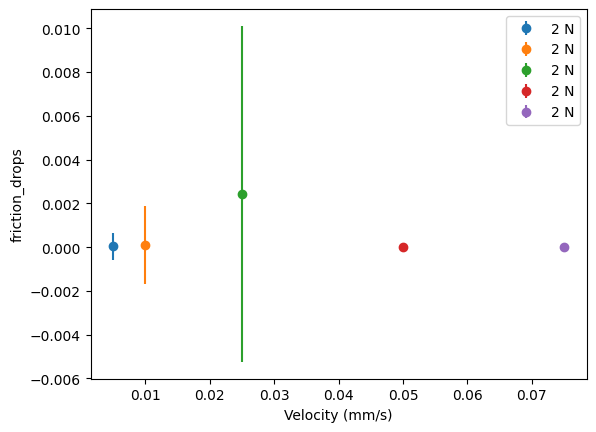

121
54
28
14


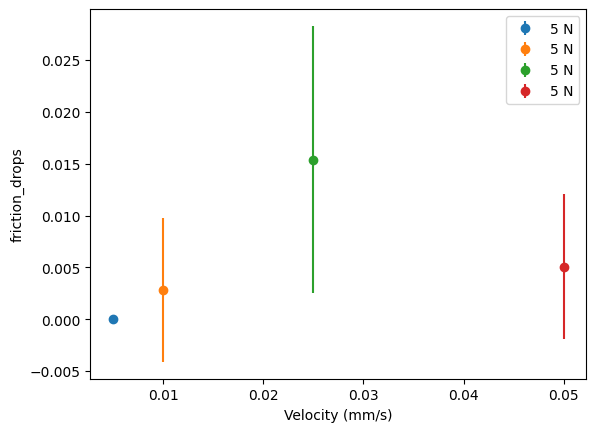

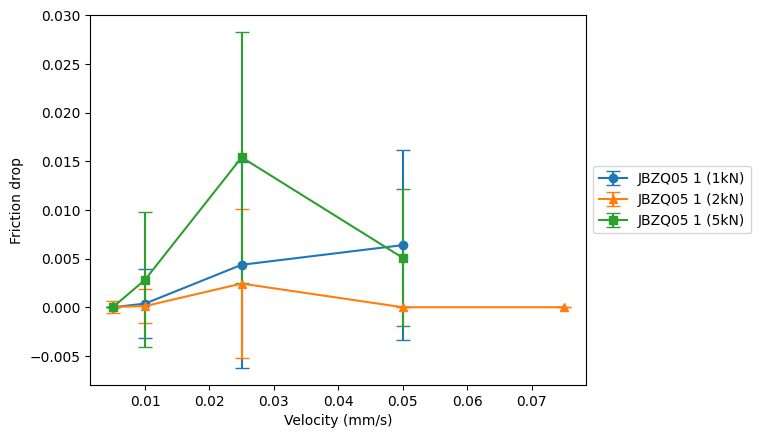

In [26]:
nbins = 30
jbzq051m, jbzq051s = plot_variable_vs_velocity(jbzq05_stress_drops_1, 'friction_drops', [0.005, 0.01, 0.025, 0.05, 0.075], [1], False)
jbzq052m, jbzq052s = plot_variable_vs_velocity(jbzq05_stress_drops_1, 'friction_drops', [0.005, 0.01, 0.025, 0.05, 0.075], [2], False)
jbzq055m, jbzq055s = plot_variable_vs_velocity(jbzq05_stress_drops_1, 'friction_drops', [0.005, 0.01, 0.025, 0.05, 0.075], [5], False)

fig, ax = plt.subplots()

ax.errorbar([0.005, 0.01, 0.025, 0.05], jbzq051m, yerr=jbzq051s, fmt='o-', label='JBZQ05 1 (1kN)', capsize=5)
ax.errorbar([0.005, 0.01, 0.025, 0.05, 0.075], jbzq052m, yerr=jbzq052s, fmt='^-', label='JBZQ05 1 (2kN)', capsize=5)
ax.errorbar([0.005, 0.01, 0.025, 0.05], jbzq055m, yerr=jbzq055s, fmt='s-', label='JBZQ05 1 (5kN)', capsize=5)

ax.set_xlabel('Velocity (mm/s)')
ax.set_ylabel('Friction drop')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Time interval

9.792716895793134
9.840342635942944
9.783507211850726
9.740060193032726


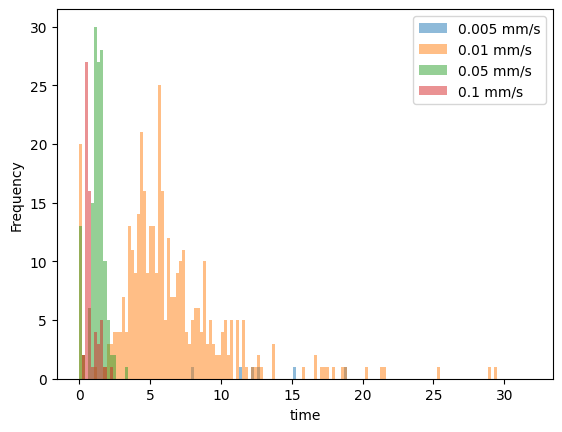

16.783514465704727
14.88152878300653
19.830966273951564


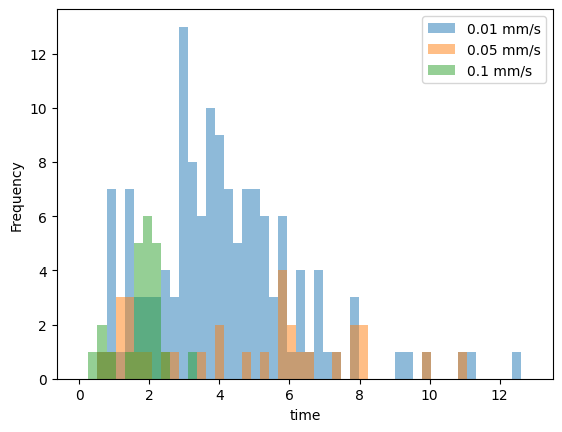

In [204]:
# At each velocity, plot the time between stress drops in a histogram (matplotlib)
plot_histogram(jbzq04_stress_drops_1, 'time', True, [0.005, 0.01, 0.05, 0.1], nbins+100)

plot_histogram(flat_stress_drops, 'time', True, [0.01, 0.05, 0.1], nbins)

### Displacement interval

7.33437712556434
17
7.274558585269069
35
7.315305877243525
60
7.334074261924037
24


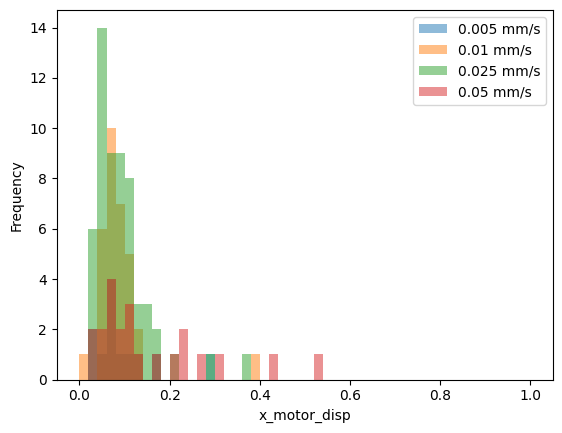

7.428778309297089
52
7.42722168240701
34
7.424951908420285
57
7.427846609344549
67


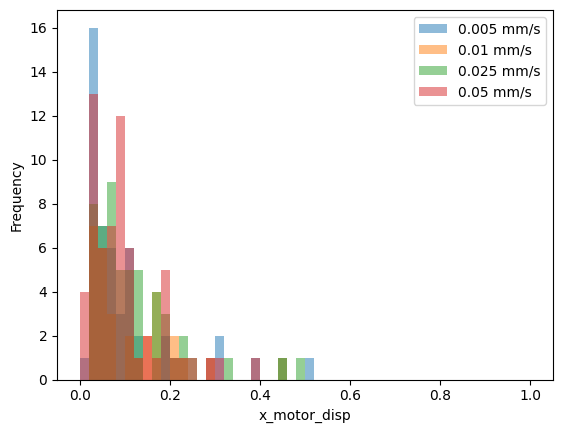

In [88]:
# plot the displacment between each stress drop
plot_histogram(jbzq04_stress_drops_3, 'x_motor_disp', [0.005, 0.01, 0.025, 0.05], nbins, True)

plot_histogram(jbzq04_stress_drops_4, 'x_motor_disp', [0.005, 0.01, 0.025, 0.05], nbins, True)